# Use of multiple agents for business context creation adn extraction

## System prompts

In [37]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a highly specialized business intelligence assistant focused on the poultry farming industry, "
        "particularly in the area of chicken farming and slaughtering (faenación de pollos). Your goal is to analyze "
        "software artifacts related to the poultry industry and extract key insights that can inform business decisions."
        " You will identify relevant business metrics, KPIs (Key Performance Indicators), statistical values, and industry benchmarks."
        " You should consider the standards and practices from reputable sources such as the book 'Pollos de Engorde' by Ross, "
        "which is a key reference in the industry."
        " If you're unsure of any metric or statistic, consult reliable industry sources."
        " If you cannot fully answer a query, it's OK—another assistant with different tools will help. However, execute what you can to make progress."
        " If you or another assistant has the final answer or deliverable, prefix your response with 'FINAL ANSWER' to indicate the task is complete."
        f"\n{suffix}"
    )

## Define agents

In [38]:
from langgraph.prebuilt import create_react_agent

# Context analyzer
context_analyzer = create_react_agent(
    llm,
    tools=[],  # No external tools yet, only LLM-based reasoning.
    prompt=(
        "You are a business intelligence expert analyzing software artifacts. "
        "Extract key insights from the provided artifact. "
        "Identify relevant business metrics, KPIs, statistical values, and industry benchmarks."
        "Do NOT generate values—only identify potential business metrics."
    )
)

# Researcher
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

researcher = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=(
        "You are a research assistant. Given a business metric or KPI, "
        "search for relevant industry standards, acceptable values, and measurement best practices."
        "Provide only reliable sources."
    )
)

# Business evaluator
from langchain_core.tools import tool

@tool
def validate_business_metrics(metrics: list):
    """
    Determines which extracted business metrics are useful.
    Returns structured KPIs, Statistics, or Visualizations.
    """
    validated_metrics = []
    for metric in metrics:
        if "KPI" in metric or "Statistic" in metric:
            validated_metrics.append(metric)
    return validated_metrics

business_evaluator = create_react_agent(
    llm,
    tools=[validate_business_metrics],
    prompt=(
        "You are a business analyst reviewing extracted metrics. "
        "Validate whether the extracted KPIs and statistics are relevant. "
        "Use industry standards where applicable."
        "Return a structured response."
    )
)

## Define nodes

In [39]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

# Context analyzer node function
def context_analyzer_node(
    state: MessagesState,
) -> Command[Literal["researcher"]]:
    """
    Analyzes the artifact to extract business metrics and KPIs, passes them to the next agent or concludes the process.
    """
    result = context_analyzer.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="context_analyzer"
    )
    
    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

# Researcher node function
def researcher_node(state: MessagesState) -> Command[Literal["business_evaluator"]]:
    """
    Researcher agent's node.
    Searches for information on a business metric or KPI and returns the result, which will be processed by the next agent.
    """
    result = researcher.invoke(state)
    goto = get_next_node(result["messages"][-1], "business_evaluator")
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )

    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

# Business Evaluator node function
def business_evaluator_node(state: MessagesState) -> Command[Literal[END]]:
    """
    Business evaluator agent's node.
    Validates extracted KPIs and Statistics using industry standards and relevance criteria.
    Returns the structured KPIs or Statistics for further processing or final output.
    """
    result = business_evaluator.invoke(state)
    goto = get_next_node(result["messages"][-1], END)
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="business_evaluator"
    )

    return Command(
        update={
            "messages": result["messages"],
        },
        goto=goto,
    )

## Workflow

In [40]:
from langgraph.graph import StateGraph, MessagesState, START

# Define the workflow graph
workflow = StateGraph(MessagesState)

# Create the agent nodes (these are the steps in the workflow)
workflow.add_node("context_analyzer", context_analyzer_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("business_evaluator", business_evaluator_node)

# Define the transitions between the nodes
workflow.add_edge(START, "context_analyzer")
#workflow.add_edge("context_analyzer", "researcher")
#workflow.add_edge("researcher", "business_evaluator")

# Compile the workflow to make it ready to run
graph = workflow.compile()

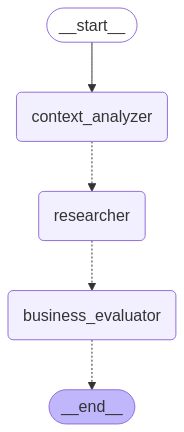

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run the system

In [47]:
import json

def read_artifact_json(file_path: str) -> str:
    with open(file_path, "r") as file:
        data = json.load(file)
        return data.get("code", "")

def read_artifact_txt(file_path: str) -> str:
    with open(file_path, "r") as file:
        return file.read()

artifact_code = read_artifact_json("../artifacts/artifact.json")
artifact_code = read_artifact_txt("../artifacts/faena_simulation.txt")

In [48]:
results = []

events = graph.stream(
    {
        "messages": [
            (
                "user",
                f"Analyze the business context of the following code artifact: {artifact_code}. "
                "Search for relevant business metrics, KPIs, and statistics. "
                "Then validate the metrics based on industry standards.",
            )
        ],
    },
    {"recursion_limit": 150},
    stream_mode="updates"
)

for s in events:
    results.append(s)
    print(s)

# with open("system_output.json", "w") as outfile:
#     json.dump(results, outfile, indent=4)

{'context_analyzer': {'messages': [HumanMessage(content='Analyze the business context of the following code artifact: import React, { useState, useEffect } from \'react\';\nimport { Card, CardContent, CardHeader, CardTitle } from \'@/components/ui/card\';\nimport { Button } from \'@/components/ui/button\';\nimport { Table, Thead, Tbody, Tr, Th, Td } from \'@/components/ui/table\';\n\n// Function to fetch data from an API\nconst fetchData = async (url, method = \'GET\', body = null) => {\n  const options = {\n    method,\n    headers: { \'Content-Type\': \'application/json\' },\n  };\n  if (body) options.body = JSON.stringify(body);\n\n  const response = await fetch(url, options);\n  if (!response.ok) {\n    throw new Error(`Failed to fetch from ${url}`);\n  }\n  return response.json();\n};\n\n// Fetching available tables from a poultry farm database\nconst fetchFarmTables = async () => {\n  return fetchData(\'https://api.poultryfarm.com/db/tables\');\n};\n\n// Fetching records from a s

In [49]:
results[0]

{'context_analyzer': {'messages': [HumanMessage(content='Analyze the business context of the following code artifact: import React, { useState, useEffect } from \'react\';\nimport { Card, CardContent, CardHeader, CardTitle } from \'@/components/ui/card\';\nimport { Button } from \'@/components/ui/button\';\nimport { Table, Thead, Tbody, Tr, Th, Td } from \'@/components/ui/table\';\n\n// Function to fetch data from an API\nconst fetchData = async (url, method = \'GET\', body = null) => {\n  const options = {\n    method,\n    headers: { \'Content-Type\': \'application/json\' },\n  };\n  if (body) options.body = JSON.stringify(body);\n\n  const response = await fetch(url, options);\n  if (!response.ok) {\n    throw new Error(`Failed to fetch from ${url}`);\n  }\n  return response.json();\n};\n\n// Fetching available tables from a poultry farm database\nconst fetchFarmTables = async () => {\n  return fetchData(\'https://api.poultryfarm.com/db/tables\');\n};\n\n// Fetching records from a s

In [50]:
results[1]

{'researcher': {'messages': [HumanMessage(content='Analyze the business context of the following code artifact: import React, { useState, useEffect } from \'react\';\nimport { Card, CardContent, CardHeader, CardTitle } from \'@/components/ui/card\';\nimport { Button } from \'@/components/ui/button\';\nimport { Table, Thead, Tbody, Tr, Th, Td } from \'@/components/ui/table\';\n\n// Function to fetch data from an API\nconst fetchData = async (url, method = \'GET\', body = null) => {\n  const options = {\n    method,\n    headers: { \'Content-Type\': \'application/json\' },\n  };\n  if (body) options.body = JSON.stringify(body);\n\n  const response = await fetch(url, options);\n  if (!response.ok) {\n    throw new Error(`Failed to fetch from ${url}`);\n  }\n  return response.json();\n};\n\n// Fetching available tables from a poultry farm database\nconst fetchFarmTables = async () => {\n  return fetchData(\'https://api.poultryfarm.com/db/tables\');\n};\n\n// Fetching records from a selecte

In [51]:
results[-1]

{'business_evaluator': {'messages': [HumanMessage(content='Analyze the business context of the following code artifact: import React, { useState, useEffect } from \'react\';\nimport { Card, CardContent, CardHeader, CardTitle } from \'@/components/ui/card\';\nimport { Button } from \'@/components/ui/button\';\nimport { Table, Thead, Tbody, Tr, Th, Td } from \'@/components/ui/table\';\n\n// Function to fetch data from an API\nconst fetchData = async (url, method = \'GET\', body = null) => {\n  const options = {\n    method,\n    headers: { \'Content-Type\': \'application/json\' },\n  };\n  if (body) options.body = JSON.stringify(body);\n\n  const response = await fetch(url, options);\n  if (!response.ok) {\n    throw new Error(`Failed to fetch from ${url}`);\n  }\n  return response.json();\n};\n\n// Fetching available tables from a poultry farm database\nconst fetchFarmTables = async () => {\n  return fetchData(\'https://api.poultryfarm.com/db/tables\');\n};\n\n// Fetching records from a